<a href="https://colab.research.google.com/github/Ozziekins/ColabWorks/blob/main/Ozioma_Okonicha_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import *
import numpy as np

x = np.load('x.npy')
y = np.load('y.npy')

print(x.shape)

(50000, 28, 28, 1)


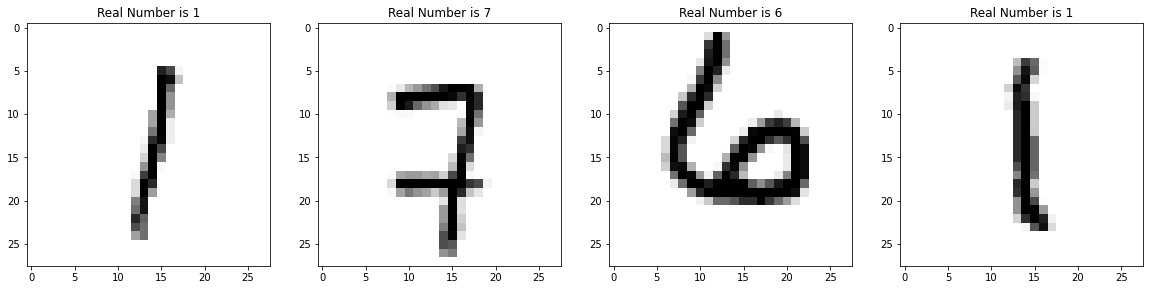

In [ ]:
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# g = plt.imshow(x[0][:,:,0])

X = x.reshape(x.shape[0], 28, 28)
Y = utils.to_categorical(y)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X[i], cmap='binary')
    digit = Y[i].argmax()
    ax.set(title = f"Real Number is {digit}");

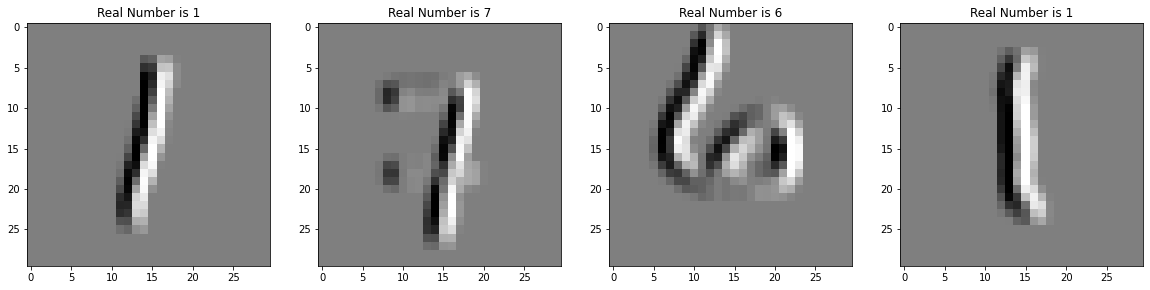

In [ ]:
vertical_kernel = np.array([[-1, 0, 1], 
                            [-1, 0, 1], 
                            [-1, 0, 1]])

horizontal_kernel = np.array([[1, 1, 1], 
                              [0, 0, 0], 
                              [-1, -1, -1]])

def convolve(img, kernel):
        # result = np.zeros(img.shape)
        # apply kernel on input image such that the image size is preserved
        n, f = img.shape[0], kernel.shape[0]
    
        # Add padding to the input image
        img = np.pad(img, (f - 1) // 2)

        # Apply kernel on the input image
        result = np.zeros(img.shape)
        for i in range(n):
            for j in range(n):
                result[i, j] = np.sum(img[i : i+f, j : j+f] * kernel)
        
        return result

# c = convolve(gray_image, vertical_kernel)
# plt.imshow(c)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(convolve(X[i], vertical_kernel), cmap='binary')
    digit = Y[i].argmax()
    ax.set(title = f"Real Number is {digit}");


def myFunc(X):
    for i in range(X.shape[0]):
        X[i] = convolve(X[i], vertical_kernel)
    return X

In [ ]:
def my_model():
    model = Sequential()
    model.add(layers.Conv2D(filters=96, kernel_size=5,
                     input_shape=(28, 28, 1), activation='relu', use_bias=False))
    model.add(layers.Conv2D(filters=96, kernel_size=3,
                            activation='relu',
                            use_bias=False))
    model.add(layers.MaxPool2D(pool_size=2, strides=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(filters=128, kernel_size=3,
                     activation='relu', use_bias=False))
    # model.add(layers.Conv2D(filters=128, kernel_size=2,
    #                  activation='relu', use_bias=False))
    model.add(layers.MaxPool2D(pool_size=2, strides=1))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.01),
                           bias_regularizer=regularizers.l2(0.0001),
                           activity_regularizer=regularizers.l2(0.000001),
                           activation='relu', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(96, kernel_regularizer=regularizers.l2(0.01),
                           bias_regularizer=regularizers.l2(0.0001),
                           activity_regularizer=regularizers.l2(0.000001),
                           activation='relu', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    return model


In [ ]:
model = my_model()
# model.load_weights("weights.best.hdf5")
model.compile(optimizers.Adam(1e-4, clipnorm=1),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=10,
                                         restore_best_weights=True)


In [ ]:
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.3,
                                          patience=6)

learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.01)

In [ ]:
import math

def schedule(epoch_idx, lr):
    if epoch_idx == 10:
        return lr * 0.35
    if epoch_idx == 20:
        return lr * 0.35
    return lr

# def exp_decay(epoch):
#    initial_lrate = 0.1
#    k = 0.1
#    lrate = initial_lrate * math.exp(-k*t)
#    return lrate

exp_decay = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.9)

def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lr_schedule2 = callbacks.LearningRateScheduler(lr_scheduler)


In [ ]:
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (3, 0.05),
    (6, 0.01),
    (9, 0.005),
    (12, 0.001),
]


def lrSchedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

new_lr_schedule = callbacks.LearningRateScheduler(lrSchedule)

In [ ]:
class LrRangeFinder(callbacks.Callback):
  def __init__(self, start_lr, end_lr):
    super().__init__()
    self.start_lr = start_lr
    self.end_lr = end_lr

  def on_train_begin(self, logs={}):
    self.lrs = []
    self.losses = []
    backend.set_value(self.model.optimizer.lr, self.start_lr)

    n_steps = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
    n_steps *= self.params['epochs']
    self.by = (self.end_lr - self.start_lr) / n_steps


  def on_batch_end(self, batch, logs={}):
    lr = float(backend.get_value(self.model.optimizer.lr))
    self.lrs.append(lr)
    self.losses.append(logs.get('loss'))
    lr += self.by
    backend.set_value(self.model.optimizer.lr, lr)

In [ ]:
lrRangeFinder = LrRangeFinder(start_lr=0.1, end_lr=2)

In [ ]:
checkpoint = callbacks.ModelCheckpoint("weights.best.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# generator = preprocessing.image.ImageDataGenerator(rotation_range=20,
#                                width_shift_range=0.1,
#                                height_shift_range=0.1,
#                                zoom_range=0.15,
#                                horizontal_flip=False,
#                                validation_split=0.15)


generator = preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=21.5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        validation_split=0.25,
        brightness_range=(0.15, 0.45),
        shear_range=0.15)


# generator = preprocessing.image.ImageDataGenerator(
#         featurewise_center=False, samplewise_center=False,
#         featurewise_std_normalization=False, samplewise_std_normalization=False,
#         zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#         height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#         channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
#         vertical_flip=False, rescale=None, preprocessing_function=None,
#         data_format=None, validation_split=0.25, dtype=None)


generator.fit(x)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 96)        2400      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 96)        82944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 96)        384       
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         110592    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [ ]:
model.fit(generator.flow(x, y, batch_size=32),
          validation_data=generator.flow(x,y, batch_size=32, subset='validation'),
          steps_per_epoch=len(x)/32,
          epochs=45, verbose=2, 
          callbacks=[early_stopping, lr_schedule2])

Epoch 1/45
1563/1562 - 31s - loss: 4.5311 - accuracy: 0.5585 - val_loss: 2.8031 - val_accuracy: 0.8866
Epoch 2/45
1563/1562 - 31s - loss: 2.3006 - accuracy: 0.8439 - val_loss: 1.4708 - val_accuracy: 0.9384
Epoch 3/45
1563/1562 - 31s - loss: 1.3169 - accuracy: 0.8940 - val_loss: 0.8733 - val_accuracy: 0.9505
Epoch 4/45
1563/1562 - 31s - loss: 0.8498 - accuracy: 0.9168 - val_loss: 0.5672 - val_accuracy: 0.9632
Epoch 5/45
1563/1562 - 31s - loss: 0.6348 - accuracy: 0.9262 - val_loss: 0.4479 - val_accuracy: 0.9603
Epoch 6/45
1563/1562 - 31s - loss: 0.5167 - accuracy: 0.9343 - val_loss: 0.3607 - val_accuracy: 0.9674
Epoch 7/45
1563/1562 - 31s - loss: 0.4480 - accuracy: 0.9385 - val_loss: 0.3081 - val_accuracy: 0.9723
Epoch 8/45
1563/1562 - 31s - loss: 0.3957 - accuracy: 0.9442 - val_loss: 0.2700 - val_accuracy: 0.9735
Epoch 9/45
1563/1562 - 31s - loss: 0.3551 - accuracy: 0.9485 - val_loss: 0.2532 - val_accuracy: 0.9713
Epoch 10/45
1563/1562 - 31s - loss: 0.3388 - accuracy: 0.9507 - val_loss:

In [ ]:
loss, acc = model.evaluate(x, y, batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

1563/1563 [==============================] - 5s 3ms/step - loss: 0.1265 - accuracy: 0.9927

Test accuracy: 99.3%


In [ ]:
model.save('model.h5')